## Welcome

This is material for the **Matching and Subclassification** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [ ]:
import pandas as pd
import numpy as np
import plotnine as p ##not for new
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)
    

In [ ]:
# Subclassification
##Read data
titanic = read_data("titanic.dta")

In [ ]:
titanic['d'] = 0
titanic.loc[titanic['class']=='1st class', 'd'] = 1

titanic['sex_d'] = 0
titanic.loc[titanic['sex']=='man', 'sex_d'] = 1

titanic['age_d'] = 0
titanic.loc[titanic['age']=='adults', 'age_d'] = 1

titanic['survived_d'] = 0
titanic.loc[titanic['survived']=='yes', 'survived_d'] = 1


In [ ]:
## Simple Difference in Outcomes
ey0 = titanic.loc[titanic['d']==0, 'survived_d'].mean()
ey1 = titanic.loc[titanic['d']==1, 'survived_d'].mean()

sdo = ey1 - ey0
print("The simple difference in outcomes is {:.2%}".format(sdo))

The simple difference in outcomes is 35.38%


In [ ]:
from itertools import combinations 


In [ ]:
## Weighted Average Treatment Effect 
titanic['s'] = 0 
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==1), 's'] = 1
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==0), 's'] = 2
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==1), 's'] = 3
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==0), 's'] = 4

obs = titanic.loc[titanic.d == 0].shape[0]

def weighted_avg_effect(df):
    diff = df[df.d==1].survived_d.mean() - df[df.d==0].survived_d.mean()
    weight = df[df.d==0].shape[0]/obs
    return diff*weight

wate = titanic.groupby('s').apply(weighted_avg_effect).sum()

print("The weighted average treatment effect estimate is {:.4%}".format(wate))  

The weighted average treatment effect estimate is 18.8785%


# Questions
- Using the simple difference in outcomes, how much does the probability of survival increase for first-class passengers relative to some control group?
- Explain in your own words what stratifying on gender and age did for this difference in outcomes between treatment and control?
- After stratifying on gender and age, what happens to the difference in probability of survival between first-class and non-first-class passengers?



## Training Example

First, we will look at the distribution of age between the treated and non-treated groups

In [ ]:
# Exact Matching
training_example = read_data("training_example.dta")
training_example.tail() ########################SLICE!!####

,unit_treat,age_treat,earnings_treat,unit_control,age_control,earnings_control,unit_matched,age_matched,earnings_matched
20,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,24.3,11075,NaN,31.95,11101.25,NaN,NaN,9380.0
22,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,SDO,-26.25,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,ATE,1695.00,NaN,NaN,NaN,NaN,NaN


In [ ]:
training_example = read_data("training_example.dta").iloc[:-5] 

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 10 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


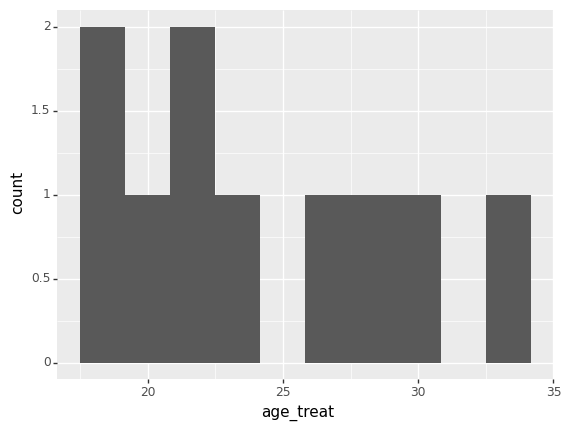

<ggplot: (8780660916273)>

In [ ]:
p.ggplot(training_example, p.aes(x='age_treat')) +\
  p.geom_histogram(bins = 10)    ##### same as R but not as Stata

(array([2., 1., 2., 0., 1., 0., 1., 1., 1., 1.]),
 array([18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. ]),
 <a list of 10 Patch objects>)

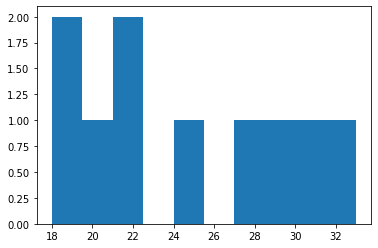

In [ ]:
plt.hist(training_example.age_treat, bins=10) #More similar to Stata, but correct

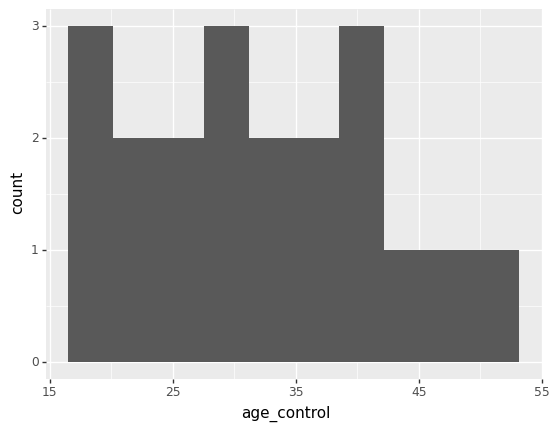

<ggplot: (8780625988437)>

In [ ]:
p.ggplot(training_example, p.aes(x='age_control')) +\
  p.geom_histogram(bins = 10)

(array([4., 2., 1., 3., 2., 1., 4., 1., 0., 2.]),
 array([18. , 21.3, 24.6, 27.9, 31.2, 34.5, 37.8, 41.1, 44.4, 47.7, 51. ]),
 <a list of 10 Patch objects>)

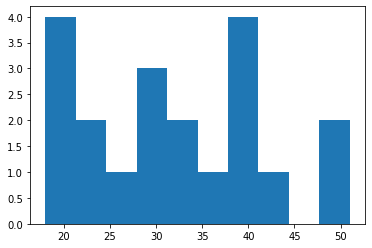

In [ ]:
plt.hist(training_example.age_control, bins=10)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 10 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


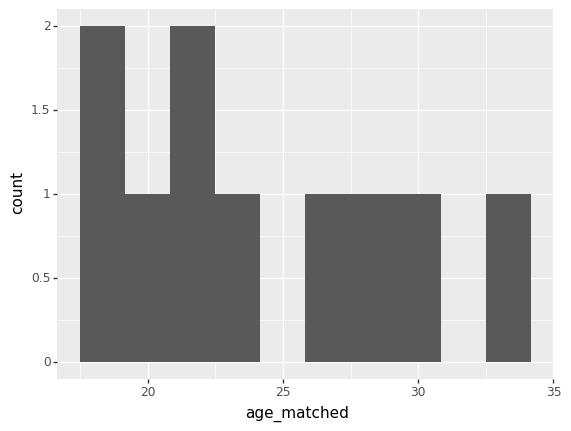

<ggplot: (8780625924685)>

In [ ]:
################### The Stata dataset has earnings_treat stored as character. The code compares again age control instead of age matched
################### R code doesn't show histogram and doesn't show the means
p.ggplot(training_example, p.aes(x='age_matched')) +\
  p.geom_histogram(bins = 10)  ############# Missing histogram

(array([2., 1., 2., 0., 1., 0., 1., 1., 1., 1.]),
 array([18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. ]),
 <a list of 10 Patch objects>)

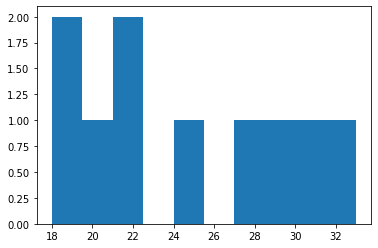

In [ ]:
plt.hist(training_example.age_matched, bins=10)

In [ ]:
### Missing means
training_example[["age_treat", "age_control", "age_matched"]].describe()

,age_treat,age_control,age_matched
count,10.000000,20.000000,10.000000
mean,24.300000,31.950000,24.300000
std,5.165054,9.665321,5.165054
min,18.000000,18.000000,18.000000
25%,20.250000,23.500000,20.250000
50%,23.000000,31.500000,23.000000
75%,28.500000,39.000000,28.500000
max,33.000000,51.000000,33.000000


In [ ]:
training_example["earnings_treat"].describe()  ########### convert to numeric in source? 

count     20
unique    11
top         
freq      10
Name: earnings_treat, dtype: object

In [ ]:
training_example[["earnings_treat", "earnings_control",  "earnings_matched"]].describe() 

,earnings_control,earnings_matched
count,20.00000,10.000000
mean,11101.25000,9380.000000
std,2227.83638,1085.241909
min,8050.00000,8050.000000
25%,8987.50000,8556.250000
50%,11087.50000,9175.000000
75%,12775.00000,10025.000000
max,15475.00000,11425.000000


#### Questions

- Compare the distribution of ages between the treated and the control groups. How do they differ, if at all?


In [ ]:
# Approximate Matching
## Bias Correction
training_bias_reduction = read_data("training_bias_reduction.dta") 

In [ ]:
training_bias_reduction['Y1'] = 0
training_bias_reduction.loc[training_bias_reduction['Unit'].isin(range(1,5)), 'Y1'] = 1
training_bias_reduction['Y0'] = (4,0,5,1,4,0,5,1)

In [ ]:
train_reg = sm.OLS.from_formula('Y ~ X', training_bias_reduction).fit()
training_bias_reduction['u_hat0'] = train_reg.predict(training_bias_reduction)
training_bias_reduction = training_bias_reduction[['Unit', 'Y1', 'Y0', 'Y', 'D', 'X', 'u_hat0']]

training_bias_reduction



,Unit,Y1,Y0,Y,D,X,u_hat0
0,1,1,4,5,1,11,3.888071
1,2,1,0,2,1,7,4.082474
2,3,1,5,10,1,5,4.179676
3,4,1,1,6,1,3,4.276878
4,5,0,4,4,0,10,3.936672
5,6,0,0,0,0,8,4.033873
6,7,0,5,5,0,4,4.228277
7,8,0,1,1,0,1,4.374080


## National Supported Work Demonstration Experiment

To compare results, let's first look at the treatment effect identified by a true experiment.


In [ ]:
nsw_dw = read_data('nsw_mixtape.dta')

mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.35


#### Questions
- How do you interpret the above estimated ATE?
- Say you were interested in the ATT.  Can you report the ATT from a randomized experiment?  If so, what is it? If not, why not?



Now, lets turn to a non-experimental control group. We first have to load the data from the CPS. and estimate the propensity score


In [ ]:
# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

In [ ]:
nsw_dw_treated = nsw_dw[nsw_dw['treat']==1] ######### Missing filter, only treated from nsw_dw

In [ ]:
nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw_treated))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + I(educ*re74)""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

In [ ]:
nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

treat
0.0    0.006648
1.0    0.425357
Name: pscore, dtype: float64

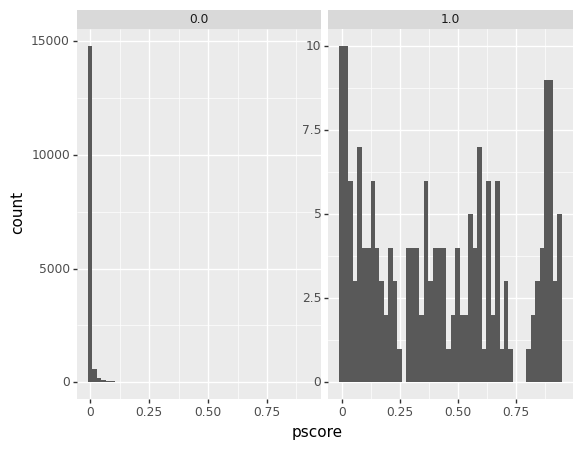

<ggplot: (8780625889889)>

In [ ]:
# histogram
p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) +\
    p.geom_histogram(bins=50) +\
    p.facet_wrap("treat", scales='free')

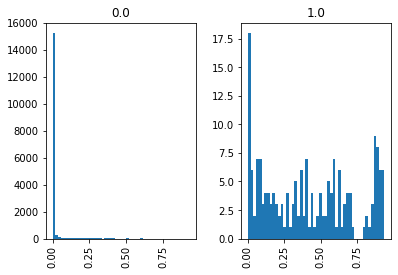

In [ ]:
histpsc = nsw_dw_cpscontrol.hist(column='pscore',by='treat',bins=50)

#### Questions
- Compare the mean propensity score between the treated and the control groups. What does this reveal about the two groups?
- Compare the distribution of propensity scores between the treated and the control groups. How do they differ, if at all?


In [ ]:
# continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        


Treatment Effect (non-normalized, all data): -11876.79


In [ ]:
nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))
        

Treatment Effect (normalized, all data): -7238.14


In [ ]:
nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))

Treatment Effect (non-normalized, trimmed data): 2006.37


In [ ]:
################## Update of d0m d1 and the sums was missing
nsw_dw_trimmed['d1'] = nsw_dw_trimmed.treat/nsw_dw_trimmed.pscore
nsw_dw_trimmed['d0'] = (1-nsw_dw_trimmed.treat)/(1-nsw_dw_trimmed.pscore)

s1 = nsw_dw_trimmed.d1.sum()
s0 = nsw_dw_trimmed.d0.sum()

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (normalized, trimmed data): 1806.73


#### Questions

- Explain the overlap condition in the context of these data.  How did we ensure that overlap held in the data? 
- When we are using non-trimmed data, why is the treatment effect negative? (*hint:* it has to do with extreme probability scores)
- What does this imply about the challenges of using non-experimental data when estimating causal effects, and why is conditioning on a trimmed propensity score important?


## Nearest-Neighbor Matching [not available in python]


#### Questions
- Compare our results from nearest-neighbor matching to what we found using the experimental data, the simple difference in outcomes using non-experimental controls, and propensity score weighting using non-experimental controls.
- DIFFICULT: Write a program that performs bootstrapping to get an estimate of the variance of the estimator. (HINT: Write a loop)



In [ ]:
## Nearest-neighbor matching
!pip install causalinference
from causalinference import CausalModel

     |████████████████████████████████| 51 kB 3.0 MB/s 


In [ ]:
############## Same as Stata in estimation, not in se
cm = CausalModel(
    Y=nsw_dw_cpscontrol.re78.values, 
    D=nsw_dw_cpscontrol.treat.values, 
    X=nsw_dw_cpscontrol.pscore.values
)

cm.est_via_matching(matches=5, bias_adj=False)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE  -7835.992   3143.007     -2.493      0.013 -13996.285  -1675.699
           ATC  -7946.597   3177.913     -2.501      0.012 -14175.306  -1717.889
           ATT   1725.082   1141.487      1.511      0.131   -512.234   3962.397



In [ ]:
## Coarsened exact matching
#   ATT in Stata 2519.446 if filtered data is used

In [ ]:
# Package that measures imbalance. Also should return weights, but doesn't seem to work well
!pip install cem
from cem import CEM

In [65]:
cem_nsw_df = nsw_dw_cpscontrol.drop(columns=["data_id","pscore","d1","d0","y1","y0","ht"]) # delete variables of previous methods. Also delete data_id, since divides exactly treatment and control observations, and thus the imbalance is 1

In [ ]:
# calculate data imbalance
c = CEM(cem_nsw_df , "treat", "re78")
c.imbalance()

Calculating H, this may take a few minutes.


0.945492181926626

In [66]:
cem_nsw_df["agesq"]=cem_nsw_df.age*cem_nsw_df.age
cem_nsw_df["agecube"]=cem_nsw_df.age*cem_nsw_df.age*cem_nsw_df.age
cem_nsw_df["edusq"]=cem_nsw_df.educ*cem_nsw_df.educ
cem_nsw_df["interaction1"]=cem_nsw_df.educ*cem_nsw_df.re74

In [67]:
# Coarsen in 5 or 6 bins
schema = {
   'age': ('cut', {'bins': 6}),
   'educ': ('cut', {'bins': 6}),
   're74': ('qcut', {'q': 5}),
   're75': ('qcut', {'q': 5})
}

In [ ]:
# Imbalance when coarsening
c.imbalance(schema)

0.4274193652727862

In [68]:
# Output of the weights, needed for the weighted regression, has more observations
weights_cem = c.match(schema)
weights_cem.describe()


count    16189.000000
mean         0.072680
std          0.794697
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         50.277778
Name: weights, dtype: float64

In [69]:
cem_nsw_df['weight_cem']=weights_cem.array # length doesn't match

ValueError: ignored

In [ ]:
# Try of weighted regression
wls_model = sm.WLS(cem_nsw_df.re78,cem_nsw_df.treat, weights=weights_cem)
res_wls = wls_model.fit()
print(res_wls.summary())

ValueError: ignored

In [71]:

# Try cem package coarsening only age variable, with same bins as in Stata
binsage = pd.IntervalIndex.from_tuples([(0, 10), (10,20), (20,30), (30,40), (40,60)])
schema = {
   'age': ('cut', {'bins': binsage})
}

In [ ]:
c.imbalance(schema)

0.48829277724892906

In [73]:
weights_cem = c.match(schema)
weights_cem.describe() #same length this time

count    16177.000000
mean         0.023614
std          0.347138
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.300000
Name: weights, dtype: float64

In [74]:
m = smf.wls(formula = 're78 ~ treat', weights = weights_cem, data = cem_nsw_df).fit()

m.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:740: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.659
Date:                Wed, 05 Jan 2022   Prob (F-statistic):             0.0309
Time:                        03:04:06   Log-Likelihood:                   -inf
No. Observations:               16177   AIC:                               inf
Df Residuals:                   16175   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.661e+04     74.752    222.137      0.000    1.65e+04    1.68e+04
treat      -7219.3171   3344.592     -2.159      0.031   -1.38e+04    -663.546
==============================================================================
Omnibus:                    13172.847   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44623322.240
Skew:                          -2.373   Prob(JB):                         0.00
Kurtosis:                     260.255   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
cem_nsw_df['weight_cem']=weights_cem.array

ValueError: ignored

In [76]:
wls_model = sm.WLS(cem_nsw_df.re78,cem_nsw_df.treat, weights=cem_nsw_df.weight_cem) 
res_wls = wls_model.fit()
print(res_wls.summary()) # different result than using formula 

                                 WLS Regression Results                                
Dep. Variable:                   re78   R-squared (uncentered):                   0.000
Model:                            WLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.945
Date:                Wed, 05 Jan 2022   Prob (F-statistic):                       0.163
Time:                        03:04:41   Log-Likelihood:                            -inf
No. Observations:               16177   AIC:                                        inf
Df Residuals:                   16176   BIC:                                        inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:740: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


In [77]:
wls_model = sm.WLS(cem_nsw_df.re78,cem_nsw_df.treat, weights=weights_cem)
res_wls = wls_model.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                   re78   R-squared (uncentered):                   0.000
Model:                            WLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.945
Date:                Wed, 05 Jan 2022   Prob (F-statistic):                       0.163
Time:                        03:05:39   Log-Likelihood:                            -inf
No. Observations:               16177   AIC:                                        inf
Df Residuals:                   16176   BIC:                                        inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:740: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


In [80]:
# without schema, all the observations should have weight 1
weights_cem = c.match()

In [81]:
weights_cem.describe() #more than observations

count    16199.000000
mean         0.102114
std          1.282078
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         86.451613
Name: weights, dtype: float64

In [117]:
## Coarsened exact matching
## Following code from https://theeffectbook.net/ch-Matching.html?highlight=python&panelset=python-code&panelset1=python-code2
cem_nsw_df = nsw_dw_cpscontrol.drop(columns=["data_id","pscore","d1","d0","y1","y0","ht"]) 
cem_nsw_df["agesq"]=cem_nsw_df.age*cem_nsw_df.age
cem_nsw_df["agecube"]=cem_nsw_df.age*cem_nsw_df.age*cem_nsw_df.age
cem_nsw_df["edusq"]=cem_nsw_df.educ*cem_nsw_df.educ
cem_nsw_df["interaction1"]=cem_nsw_df.educ*cem_nsw_df.re74

In [118]:
cem_nsw_df['age_bins'] = pd.cut(cem_nsw_df['age'], binsage)

In [119]:
# Count how many treated and control observations
# are in each bin
treated = cem_nsw_df.loc[cem_nsw_df['treat'] == 1
].groupby(['age_bins']).size().to_frame('treated')
control = cem_nsw_df.loc[cem_nsw_df['treat'] == 0
].groupby(['age_bins']).size().to_frame('control')

In [107]:
print(treated)

          treated
age_bins         
(0, 10]         0
(10, 20]       47
(20, 30]      102
(30, 40]       23
(40, 60]       13


In [108]:
print(control)

          control
age_bins         
(0, 10]         0
(10, 20]     2128
(20, 30]     5491
(30, 40]     3874
(40, 60]     4499


In [120]:
# Merge those counts back in
cem_nsw_df = cem_nsw_df.join(treated, on = ['age_bins'])
cem_nsw_df = cem_nsw_df.join(control, on = ['age_bins'])

In [122]:
# For control obs, weight depends on total number of treated and control obs that found matches
totalcontrols = sum(cem_nsw_df.loc[cem_nsw_df['treat']==0]['treated'] > 0)
totaltreated = sum(cem_nsw_df.loc[cem_nsw_df['treat']==1]['control'] > 0)
print(totalcontrols)
print(totaltreated)
overall = totalcontrols/totaltreated
print(overall)

15992
185
86.44324324324324


In [130]:
# Then, control weights are treated/control in the bin, relative to treated/control overall 
# Is that correct?
cem_nsw_df['aux_cont_wg'] = (cem_nsw_df['treated']/cem_nsw_df['control'])/overall

In [131]:
cem_nsw_df['weight_cem'] = cem_nsw_df['aux_cont_wg']
cem_nsw_df.loc[(cem_nsw_df['treat'] == 1) & (cem_nsw_df['control'] > 0), 'weight_cem'] = 1 # For treated obs, weight is 1 if there are any control matches
cem_nsw_df.loc[(cem_nsw_df['treat'] == 1) & (cem_nsw_df['control'] == 0), 'weight_cem'] = 0 # For treated obs without control matches the weight is 0

In [132]:
wls_model = sm.WLS(cem_nsw_df.re78,cem_nsw_df.treat, weights=cem_nsw_df.weight_cem) 
res_wls = wls_model.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                   re78   R-squared (uncentered):                   0.002
Model:                            WLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              27.24
Date:                Wed, 05 Jan 2022   Prob (F-statistic):                    1.82e-07
Time:                        03:36:59   Log-Likelihood:                     -1.8252e+05
No. Observations:               16177   AIC:                                  3.650e+05
Df Residuals:                   16176   BIC:                                  3.651e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# Try this with own coarsening of all the covariates?